In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math
%matplotlib inline

import sys
sys.path.append('../')
import networks.resnet32_gda as res
from bayes_layer import NoiseLayer

In [2]:
def NoiseLayerSTD(model_name, ratio=None, task_num=10):
    cnt = 0
    sample_num = []
    model = res.resnet32(100)
    
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, NoiseLayer) == False:
            continue
        out_features = layer.rho.shape[0]
        
        sample_num.append(out_features)
#         std_arr = np.zeros((sample_num[cnt], task_num+1))
        std_arr = np.zeros((sample_num[cnt], task_num))
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        std_init = math.sqrt(out_features*ratio)
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std[rand_idx])
#             std_arr[:,t+1] = std[rand_idx]
#             std_arr[:,t+1] = std
#             std_arr[:,t] = std[rand_idx]
            std_arr[:,t] = std
            
        reg_arr = (std_init/std_arr)**2
        rand_std.append(std_arr)
#         rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(10,8))
    for l in range(cnt):
        
        for i in range(sample_num[l]):
#             plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')
            plt.plot(np.arange(task_num), rand_std[l][i], linestyle = '-')

        fontsize = 20
#         plt.xticks(np.arange(task_num+1),fontsize = fontsize)
        plt.xticks(np.arange(task_num),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
        if l==0:
            plt.ylabel('STD',fontsize = fontsize)
#             plt.ylabel('Strength',fontsize = fontsize)
        
#         plt.ylim(0,100)
        
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')


In [3]:
def FC_weight_bias(model_name, task_num=10):
    cnt = 0
    model = res.resnet32(100)
    for (_, layer) in model.named_children():
        if isinstance(layer, nn.Linear) == False:
            continue
        bias_arr = np.zeros((100, task_num))
        
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            bias = layer.bias.data.cpu().numpy()
            bias_arr[:,t] = np.abs(bias)
            
        cnt += 1
        
    plt.figure(figsize=(10,8))
    for i in range(100):
        plt.plot(np.arange(task_num), bias_arr[i], linestyle = '-')

    fontsize = 20
    plt.xticks(np.arange(task_num),fontsize = fontsize)

    plt.xlabel('Task', fontsize = fontsize)

    plt.tight_layout()

In [4]:
sns.set_palette(sns.color_palette("husl", 100))

../networks/resnet32_gda.py:95: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


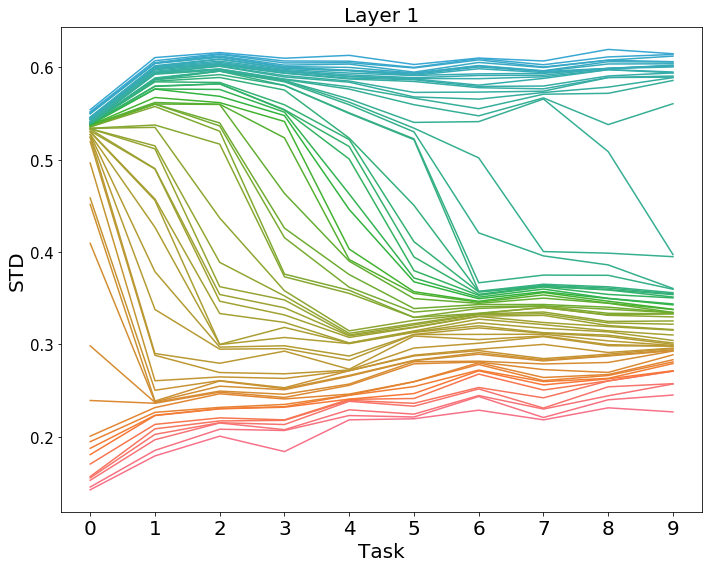

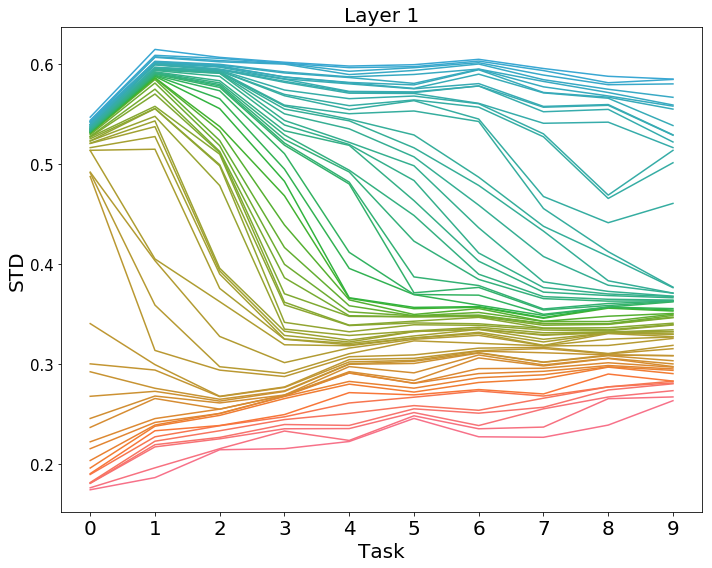

In [5]:
name = '../models/trained_model/GDA_CIFAR100_gda_0_memsz_2000_alpha_0.0001_ratio_0.50000000_beta_1e-05_lr_0.1_batch_64_epoch_100_task_%d.pt'
NoiseLayerSTD(name, ratio=0.5, task_num=10)
name = '../models/trained_model/GDA_CIFAR100_gda_0_memsz_2000_alpha_0.0001_ratio_0.00390625_beta_1e-05_lr_0.1_batch_64_epoch_100_task_%d.pt'
NoiseLayerSTD(name, ratio=0.00390625, task_num=10)


../networks/resnet32_gda.py:95: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(m.weight)


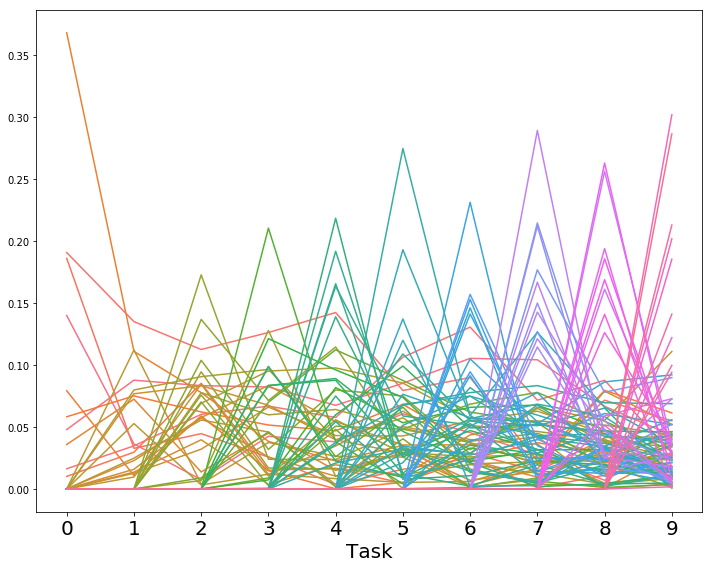

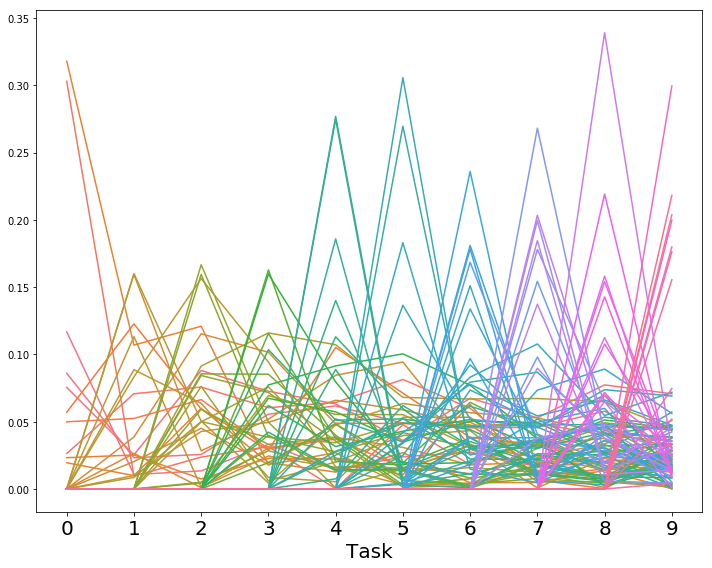

In [6]:
name = '../models/trained_model/GDA_CIFAR100_gda_0_memsz_2000_alpha_0.0001_ratio_0.50000000_beta_1e-05_lr_0.1_batch_64_epoch_100_task_%d.pt'
FC_weight_bias(name, task_num=10)
name = '../models/trained_model/GDA_CIFAR100_gda_0_memsz_2000_alpha_0.0001_ratio_0.00390625_beta_1e-05_lr_0.1_batch_64_epoch_100_task_%d.pt'
FC_weight_bias(name, task_num=10)